<a href="https://colab.research.google.com/github/dymbe/unet-reproducibility-project/blob/master/Reproducibility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Original website of the paper](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)
  
![alt text](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

# Our Architecture

First we declare all of our imports and classes for data processing. We implement data augmenation in the form of rotations and elastic transforms, and we pad the input image, using mirror padding, as described in the paper, to achieve an input of desired size, which for output of 512x512 is 700x700. We then load our data set into a dataloader, further splitting the data into train and validation sets.

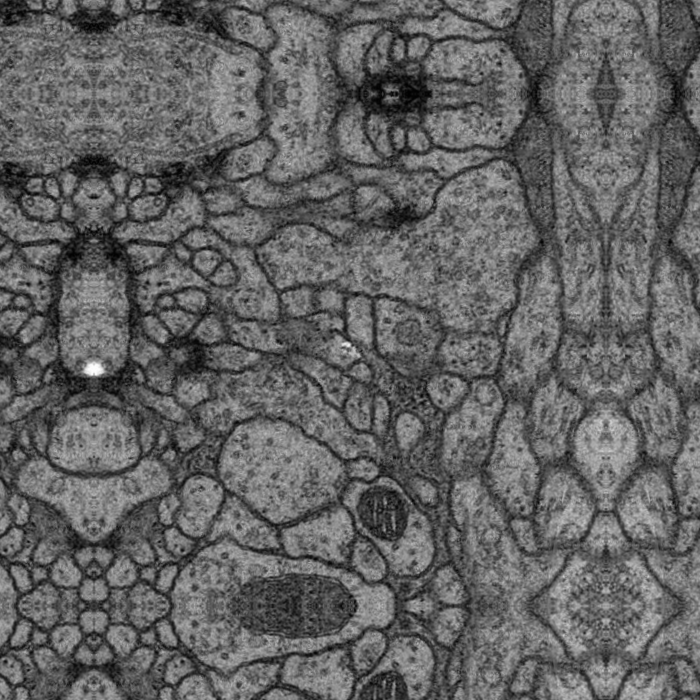

In [0]:
from collections import defaultdict
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import random
import numpy as np
from scipy.ndimage import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from time import time
import matplotlib.pyplot as plt


image = Image.open('train-volume.tif')
image_label = Image.open('train-labels.tif')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Batch size 1 for same results as paper
batch_size = 1

class Rotate(object):
  # def __init__(self):

  def __call__(self, sample):
    img, label = sample['image'], sample['label']
    angle = random.randint(0,3)*90
    img = img.rotate(angle)
    label = label.rotate(angle)
    return {'image': img, 'label': label}


def elastic_transform(image, alpha=1000, sigma=10, spline_order=1, mode='nearest', random_state=np.random):
    image = np.array(image)
    shape = image.shape

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) #* alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1),
                         sigma, mode="constant", cval=0) #* alpha

    x, y = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    indices = [np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1))]
    result = np.empty_like(image)
    result[:, :] = map_coordinates(
        image[:, :], indices, order=spline_order, mode=mode
    ).reshape(shape)
    result = Image.fromarray(result)
    return result


class ElasticTransform(object):
    def __call__(self, sample):
        img, label = sample['image'], sample['label']

        # Seed must be between 0 and 2^32 - 1
        seed = np.random.randint((2 ** 32) - 1)
        img = elastic_transform(img, random_state=np.random.RandomState(seed))
        label = elastic_transform(label, random_state=np.random.RandomState(seed))

        return {'image': img, 'label': label}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        # swap color axis because DID NOT DO THIS BECAUSE ONLY 1 CHANNEL
        # numpy image: H x W x C
        # torch image: C X H X W
        np_img = np.array(image) / (255)
        np_label = np.array(label) / (255)

        return {'image': torch.unsqueeze(torch.from_numpy(np_img).float(),0) ,
                'label': torch.unsqueeze(torch.from_numpy(np_label).float(),0) }

class MirrorPadding(object):
    def __call__(self, sample):
        image = sample['image']
        padded_img = np.pad(image, pad_width=(700-512)//2, mode="symmetric")
        sample['image'] = padded_img
        return sample

class CellDataset(Dataset):
    def __init__(self, indices=None, transform=None):
        self.transform = transform
        self.indices = indices

    def __len__(self):
        if self.indices is not None:
            return len(self.indices)
        else:
            return image.n_frames

    def __getitem__(self, index):
        if self.indices is not None:
            index = self.indices[index]

        image.seek(index)
        image_label.seek(index)
        img = image
        img_label = image_label

        sample = {'image': img, 'label': img_label}
        sample_t = self.transform(sample)

        return sample_t

trans = transforms.Compose([Rotate(),
                            ElasticTransform(),
                            MirrorPadding(),
                            ToTensor()])

train_indices = random.sample(range(0, image.n_frames), int(0.8 * image.n_frames))
val_indices = [i for i in range(0, image.n_frames) if i not in train_indices]

train_data = CellDataset(indices=train_indices, transform=trans)
val_data = CellDataset(indices=val_indices, transform=trans)

dataloaders = {
    'train': DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_data, batch_size=batch_size, shuffle=True, num_workers=0)
}

sample = next(iter(dataloaders['train']))
# print(sample['image'].shape, sample['label'].shape)
img = sample['image']
img = torch.squeeze(img,0)
display(transforms.ToPILImage()(img))

This cell is the actual architecture. We define a module for double convolution followed by a ReLU, as this operation occurs on many layers of the network. We then define a module for a step on the downward path, which is a double convolution followed by a max-pool operation. Similarly, a module for a step on the upward path, which is upconvolution, followed by a copy and crop operation, and finally a double convolution. We then assemble all the modules in the network, and finally crop the output to obtain a 512x512 predicted image, which is the same size as the given label.



In [0]:
class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def weights_init(self, m):
        if type(m) in [nn.Conv2d]:
          in_channels = m.in_channels
          nn.init.normal_(m.weight, mean=0.0, std=math.sqrt(2/(9*in_channels)))

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=0),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        self.double_conv.apply(self.weights_init)

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # We concatenate the upsampled vector with 
        # the corresponding vector from the downward path
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])
        crop_x2 =  x2[:,
                      :, 
                      diffY : (diffY + x1.size()[2]), 
                      diffX : (diffX + x1.size()[3])]

        # x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
        #                 diffY // 2, diffY - diffY // 2])
        
        
        x = torch.cat([crop_x2, x1], dim=1)
        #print("final after upconv: {}".format(x.shape))
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


"""Main Class"""
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256) 
        self.down3 = Down(256, 512) 
        self.down4 = Down(512, 1024) 
        self.up1 = Up(1024, 512, bilinear) 
        self.up2 = Up(512, 256, bilinear) 
        self.up3 = Up(256, 128, bilinear) 
        self.up4 = Up(128, 64, bilinear) 
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        logits = logits[:,:,2 : logits.size()[2]-2,2 : logits.size()[3]-2]
        return logits

In this cell we run the training procedure, collecting training and validation loss for plotting.

training
epoch:  0
time elapsed: 8.5964 seconds
training loss:  0.5402622396747271
validation loss:  0.5221972564856211


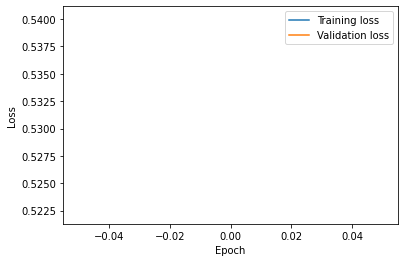

epoch:  1
time elapsed: 16.2738 seconds
training loss:  0.48657798891266185
validation loss:  0.4979042361179988


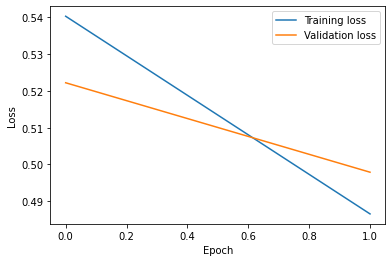

epoch:  2
time elapsed: 23.8408 seconds
training loss:  0.46959836160143215
validation loss:  0.4805823564529419


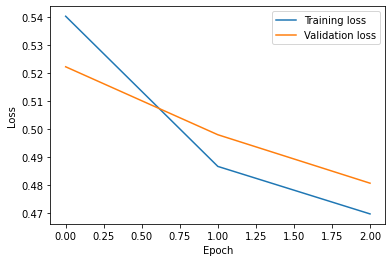

epoch:  3
time elapsed: 31.4116 seconds
training loss:  0.4640576367576917
validation loss:  0.47934359312057495


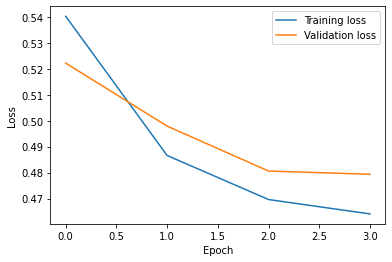

epoch:  4
time elapsed: 38.9653 seconds
training loss:  0.4613298128048579
validation loss:  0.4785914321740468


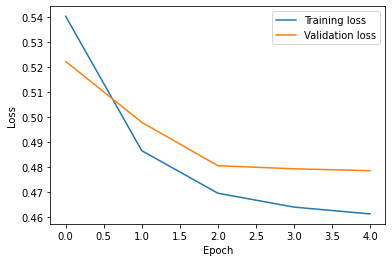

epoch:  5
time elapsed: 46.5735 seconds
training loss:  0.4587307634452979
validation loss:  0.4757099747657776


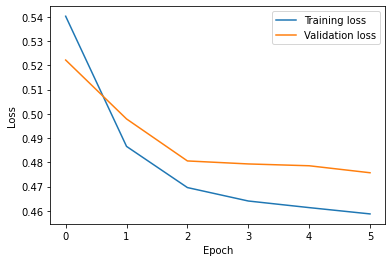

epoch:  6
time elapsed: 54.1496 seconds
training loss:  0.45676398277282715
validation loss:  0.47563715775807697


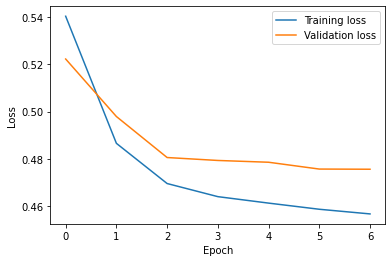

epoch:  7
time elapsed: 61.7065 seconds
training loss:  0.4510883738597234
validation loss:  0.4689866056044896


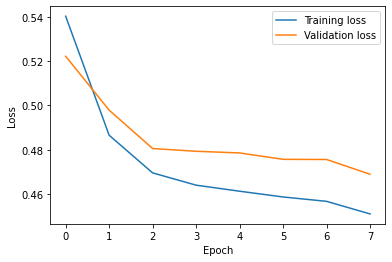

epoch:  8
time elapsed: 69.3006 seconds
training loss:  0.4501320334772269
validation loss:  0.4680273284514745


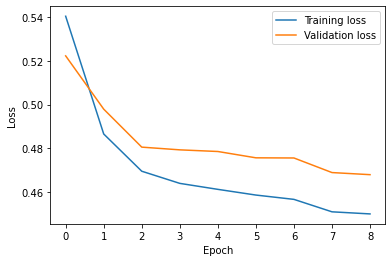

epoch:  9
time elapsed: 76.8686 seconds
training loss:  0.4543524570763111
validation loss:  0.46645427246888477


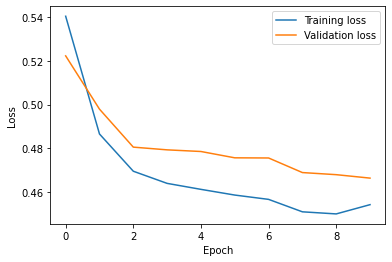

epoch:  10
time elapsed: 84.4177 seconds
training loss:  0.4486302447815736
validation loss:  0.46625209351380664


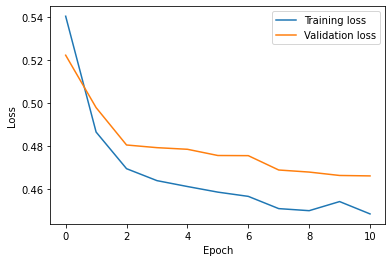

epoch:  11
time elapsed: 91.9968 seconds
training loss:  0.44847006474932033
validation loss:  0.4743015617132187


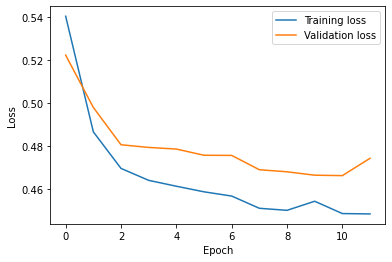

epoch:  12
time elapsed: 99.5677 seconds
training loss:  0.4471351293226083
validation loss:  0.46591774622599286


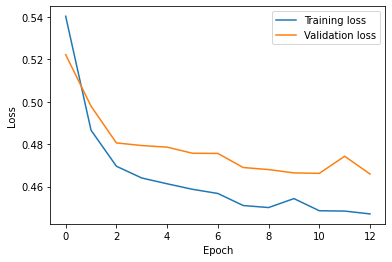

epoch:  13
time elapsed: 107.1410 seconds
training loss:  0.4453575201332569
validation loss:  0.46759267151355743


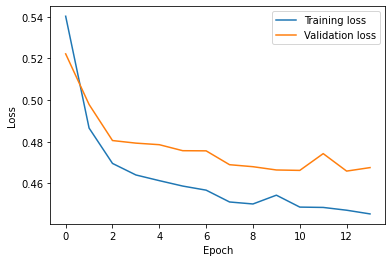

epoch:  14
time elapsed: 114.7118 seconds
training loss:  0.44663867106040317
validation loss:  0.4639122138420741


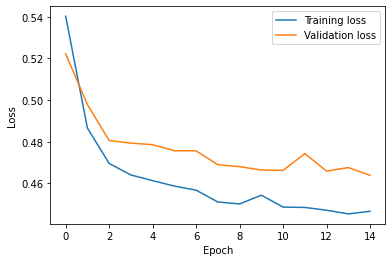

epoch:  15
time elapsed: 122.3630 seconds
training loss:  0.4442329580585162
validation loss:  0.4640275339285533


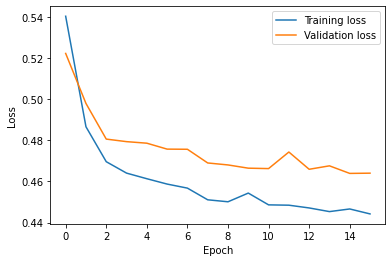

epoch:  16
time elapsed: 129.9388 seconds
training loss:  0.4471483342349529
validation loss:  0.46390505135059357


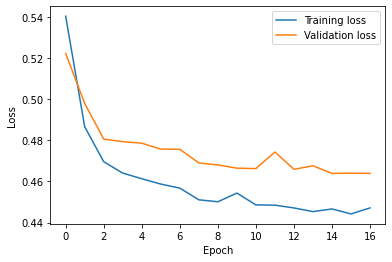

epoch:  17
time elapsed: 137.4887 seconds
training loss:  0.44473300501704216
validation loss:  0.4617679913838704


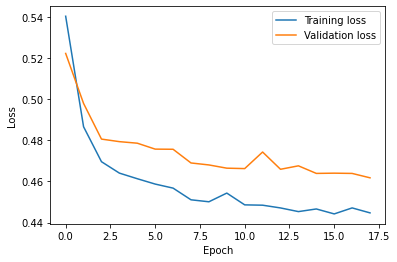

epoch:  18
time elapsed: 145.0334 seconds
training loss:  0.44452470913529396
validation loss:  0.4647718667984009


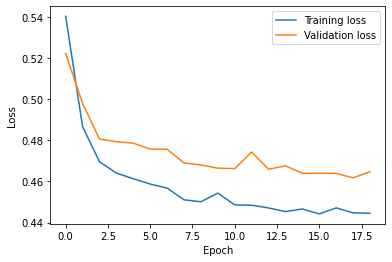

epoch:  19
time elapsed: 152.5969 seconds
training loss:  0.4434726486603419
validation loss:  0.46574940780798596


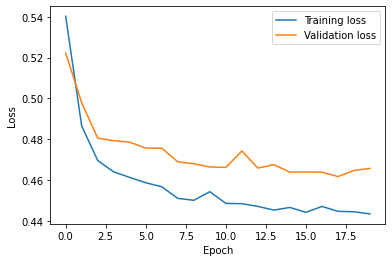

epoch:  20
time elapsed: 160.1435 seconds
training loss:  0.44410674770673114
validation loss:  0.46115557849407196


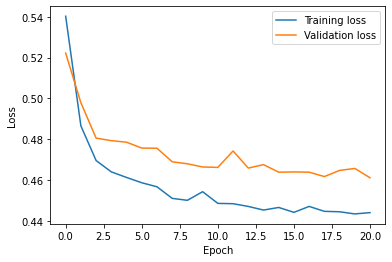

epoch:  21
time elapsed: 167.7119 seconds
training loss:  0.44236621384819347
validation loss:  0.4602685322364171


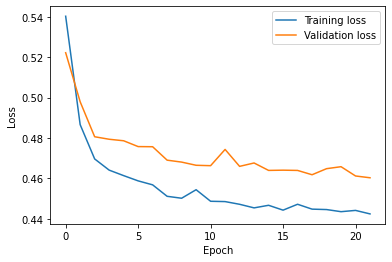

epoch:  22
time elapsed: 175.2619 seconds
training loss:  0.4415287636220455
validation loss:  0.4620826145013173


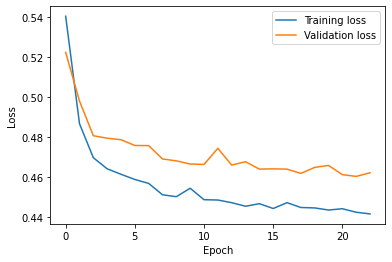

epoch:  23
time elapsed: 182.8302 seconds
training loss:  0.44201656927665073
validation loss:  0.4631600131591161


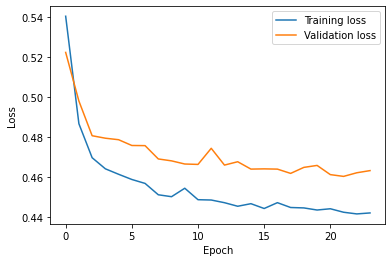

epoch:  24
time elapsed: 190.3978 seconds
training loss:  0.44123702372113865
validation loss:  0.4594552119572957


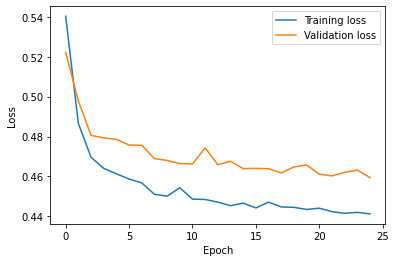

In [0]:
from torchsummary import summary
#Hyperparameters
lr = 1e-4
weight_decay = 1e-8
momentum = 0.9

def calc_loss(pred, target):
    pred = torch.sigmoid(pred).contiguous()
    target = target.contiguous()
    bce_loss = F.binary_cross_entropy_with_logits(pred, target)
    return bce_loss.mean()

def train_model(model, epochs):
    print("training")
    time_start = time()
    train_losses = []
    val_losses = []
    validation_set = [sample for sample in dataloaders['val']]

    for epoch in range(epochs):
        optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)
        train_loss = 0
        for batch in dataloaders['train']:
            pred = model(batch['image'].to(device))
            loss = calc_loss(pred, batch['label'].to(device))
            train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_value_(model.parameters(), 0.1)
            optimizer.step()
        train_loss = train_loss / len(dataloaders['train'])
        train_losses.append(train_loss)

        val_loss = 0
        for batch in validation_set:
            pred = model(batch['image'].to(device))
            loss = calc_loss(pred, batch['label'].to(device))
            val_loss += loss.item()
        val_loss = val_loss / len(validation_set)
        val_losses.append(val_loss)

        time_diff = time() - time_start
        print("epoch: ", epoch)
        print("time elapsed: {:.4f} seconds".format(time_diff))
        print("training loss: ", train_loss)
        print("validation loss: ", val_loss)
    
        x = range(epoch + 1)
        if((epoch+1) / 5):
          plt.plot(x, train_losses, label="Training loss")
          plt.plot(x, val_losses, label="Validation loss")

          plt.xlabel("Epoch")
          plt.ylabel("Loss")
          plt.legend()
          plt.show()

model = UNet(1,1) #1 input, 1 output\
model = model.to(device)
# summary(model, input_size=(1, 700, 700))
train_model(model, epochs=25)

  

In the final cell, we load the test set into the dataloader and perform the necessary mirror padding to obtain a testing image to feed into the model. We then present the predicted segmentation map.

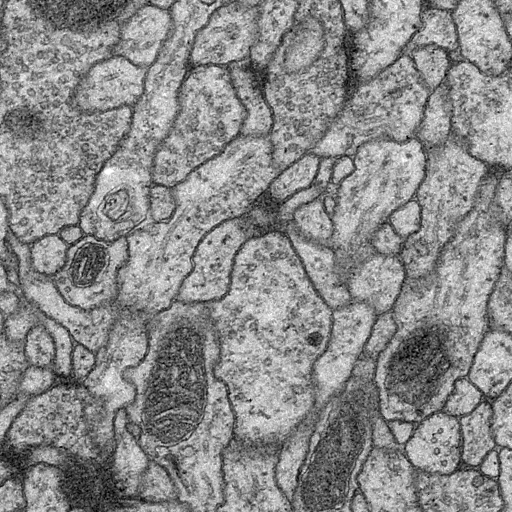

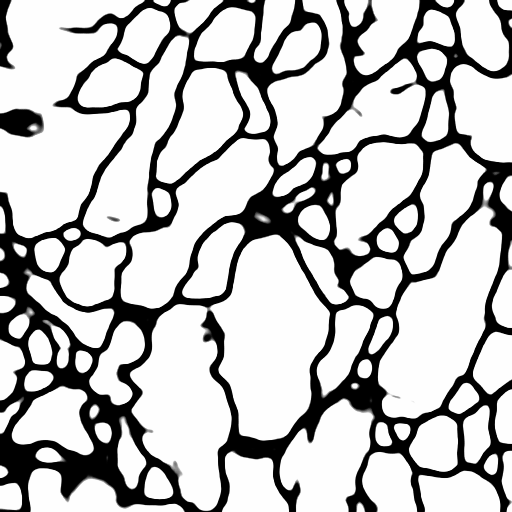

In [0]:
#Use the trained model from last cell
image_t = Image.open('test-volume.tif')
model.cpu()

# copied from tutorial 
class ToTensor_img(object):
    def __call__(self, sample):
        image = sample['image']
        np_img = np.array(image) / (255)

        return {'image': torch.unsqueeze(torch.from_numpy(np_img).float(), 0)}

class TestDataset(Dataset):
    def __init__(self):
        self.transform = transforms.Compose([MirrorPadding(),
                                             ToTensor_img()])
  
    def __len__(self):
        return image_t.n_frames
    
    def __getitem__(self, index):
        image_t.seek(index)
        img = image_t
      
        sample = {'image': img}
        sample_t = self.transform(sample)       
        return sample_t

test_data = TestDataset()

dataloaders['test'] = DataLoader(test_data, batch_size=1, shuffle=True, num_workers=0)

sample = next(iter(dataloaders['test']))
img = sample['image']
pred = model(img)
pred = torch.squeeze(torch.sigmoid(pred),0)

#print(img)
pred_img = transforms.ToPILImage()(pred)
img = torch.squeeze(img, 0)
start = (700-512)//2
img = img[:, start : 512 + start, start : 512 + start]
pil_img = transforms.ToPILImage()(img)
display(pil_img)
display(pred_img)


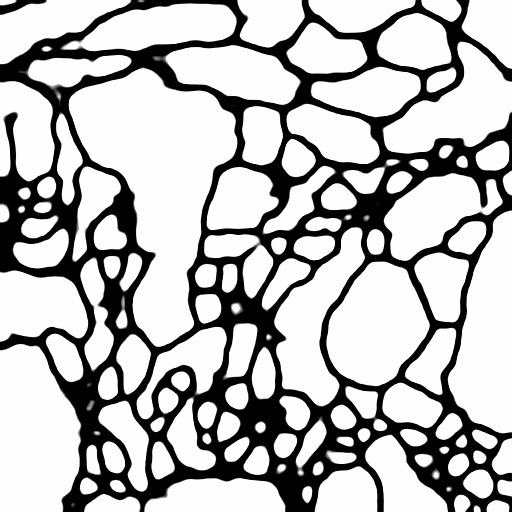

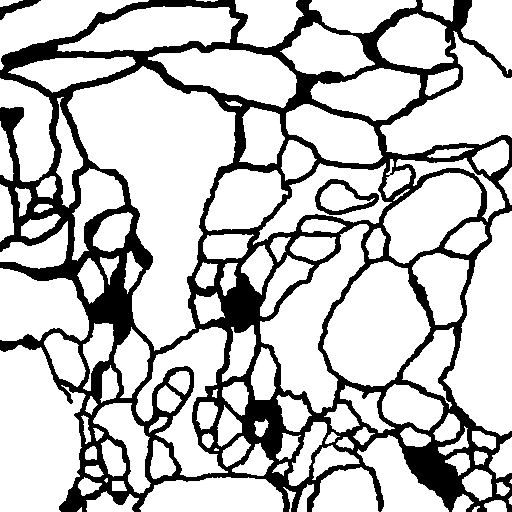

Pixel error: 0.23755645751953125


In [15]:
sample2 = next(iter(dataloaders['train']))
img2 = sample2['image'].to(device)

pred_2 = model(img2.cpu())
pred_2 = torch.squeeze(torch.sigmoid(pred_2),0)
pred_img_2 = transforms.ToPILImage()(pred_2.cpu())

display(pred_img_2)

img2_label = sample2['label']
img2_label = torch.squeeze(img2_label,0)
pil_img2_l = transforms.ToPILImage()(img2_label)
display(pil_img2_l)

# Calculating pixel error

img2 = sample2['image'].to(device)
pred_2 = model(img2.cpu())
pred_2 = torch.sigmoid(pred_2)
label = torch.where(img2_label >= 0.5, torch.ones(1), torch.zeros(1))
bpred = torch.where(torch.sigmoid(pred_2) >= 0.5, torch.ones(1), torch.zeros(1))
acc = torch.sum(bpred == label)
incorrect = 512*512 - acc
print(f"Pixel error: {incorrect / (512. * 512)}")
